### Assigned to __Deval and Eshan__

#### Main goal: 
1. Use features to create some form of input vector appropriate to model used 
2. try to do: 
    - clustering over a projection (look at checkpoint 2 and how i used pca/umap/t-sne)
    - SVMs on singular features (an array of only floats, don't input another array inside all your inputs as another feature); also see if you need to kernel trick or something 
    - ensemble method: have binary classifier for this label or not this label and trickle down
        - YES or (NO or (HAPPY or ...)) kinda like if else in ocaml 
3. give me the dihta on confusion matrix and precision recall f1

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [40]:
# load from pickle
def open_pickle(path: str):
    with open(path, "rb") as f:
        df = pickle.load(f)
    return df

df = open_pickle("./processed_data.pkl")
df
print(df.columns)
# X = np.stack(df['Spectrogram'].to_list())
X = np.stack(df['Spectrogram'].to_list()).reshape(len(df), -1)
y = df['Label'].to_list()

['Filename', 'Audio', 'ID', 'Label', 'Duration', 'Index', 'Spectrogram']


In [41]:
# Encode labels to integers
y_encoded = LabelEncoder().fit_transform(y)
label_names = LabelEncoder().fit(y).classes_

In [43]:
# Projection + Clustering (PCA, t-SNE, UMAP)
def project_and_cluster(X, y, method='pca', sample_size=500):
    if len(X) > sample_size:
        idx = np.random.choice(len(X), sample_size, replace=False)
        X = X[idx]
        y = np.array(y)[idx]

    if method == 'pca':
        projector = PCA(n_components=2)
    elif method == 'tsne':
        projector = TSNE(n_components=2, perplexity=30, n_iter=300)
    elif method == 'umap':
        projector = umap.UMAP(n_components=2)
    else:
        raise ValueError("Invalid projection method")

    X_proj = projector.fit_transform(X)
    kmeans = KMeans(n_clusters=len(set(y)))
    cluster_labels = kmeans.fit_predict(X_proj)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=y, palette='Set2', legend='full')
    plt.title(f'{method.upper()} Projection with True Labels')
    plt.show()

    return X_proj, cluster_labels

In [44]:
# SVM on Singular Features
def svm_per_feature(X, y, max_features=50):
    print("SVM on individual features:")
    for i in range(min(X.shape[1], max_features)):
        Xi = X[:, i].reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(Xi, y, test_size=0.2, random_state=42)
        clf = SVC(kernel='rbf')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
        print(f"Feature {i}: F1 Score: {f1:.3f}")

In [45]:
# Ensemble Classifier
def trickle_classifier(X, y, labels):
    classifiers = {}
    current_indices = np.arange(len(y))
    current_X, current_y = X.copy(), y.copy()
    y_pred = np.array(['unknown'] * len(y))

    for label in labels:
        # binary_y = (current_y == label).astype(int)
        binary_y = np.array([1 if lbl == label else 0 for lbl in current_y])
        clf = RandomForestClassifier()
        clf.fit(current_X, binary_y)
        preds = clf.predict(current_X)
        match = (preds == 1)

        y_pred[current_indices[match]] = label

        # Remove classified
        current_indices = current_indices[~match]
        current_X = current_X[~match]
        # current_y = current_y[~match]
        current_y = [current_y[i] for i in range(len(current_y)) if not match[i]]

        classifiers[label] = clf

    print("Classification Report:")
    print(classification_report(y, y_pred, labels=labels, zero_division=0))

    cm = confusion_matrix(y, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45)
    plt.title("Confusion Matrix - Trickle Classifier")
    plt.show()

    return classifiers

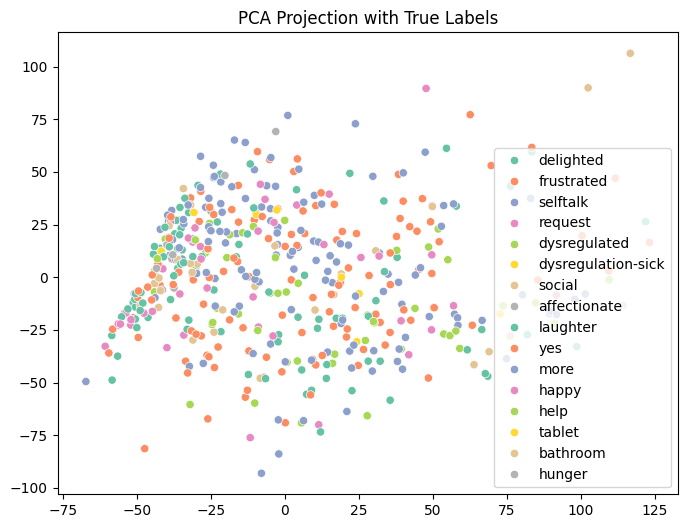

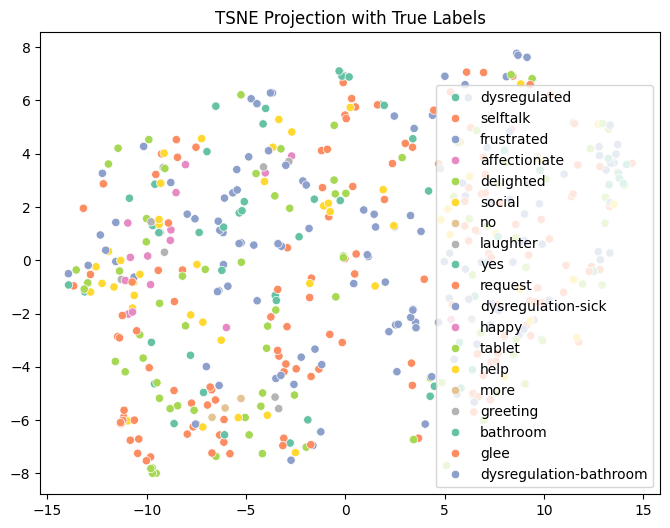

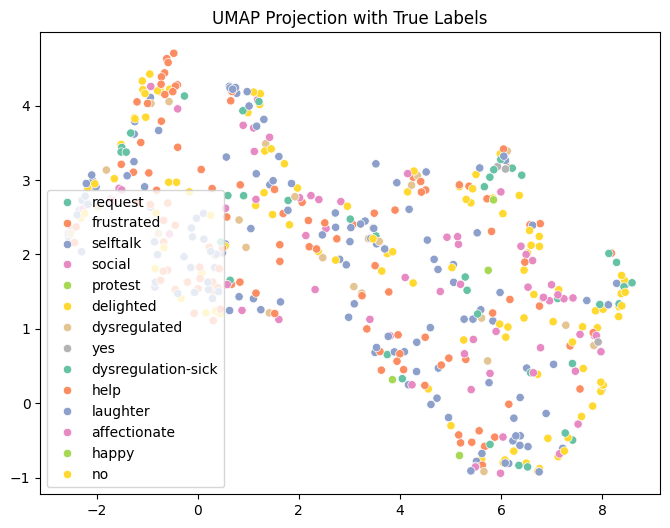

SVM on individual features:
Feature 0: F1 Score: 0.200
Feature 1: F1 Score: 0.207
Feature 2: F1 Score: 0.220
Feature 3: F1 Score: 0.220
Feature 4: F1 Score: 0.200
Feature 5: F1 Score: 0.203
Feature 6: F1 Score: 0.203
Feature 7: F1 Score: 0.201
Feature 8: F1 Score: 0.184
Feature 9: F1 Score: 0.179
Feature 10: F1 Score: 0.182
Feature 11: F1 Score: 0.190
Feature 12: F1 Score: 0.194
Feature 13: F1 Score: 0.195
Feature 14: F1 Score: 0.205
Feature 15: F1 Score: 0.201
Feature 16: F1 Score: 0.192
Feature 17: F1 Score: 0.191
Feature 18: F1 Score: 0.190
Feature 19: F1 Score: 0.196
Feature 20: F1 Score: 0.191
Feature 21: F1 Score: 0.199
Feature 22: F1 Score: 0.198
Feature 23: F1 Score: 0.210
Feature 24: F1 Score: 0.198
Feature 25: F1 Score: 0.196
Feature 26: F1 Score: 0.206
Feature 27: F1 Score: 0.195
Feature 28: F1 Score: 0.197
Feature 29: F1 Score: 0.194
Feature 30: F1 Score: 0.198
Feature 31: F1 Score: 0.198
Feature 32: F1 Score: 0.189
Feature 33: F1 Score: 0.196
Feature 34: F1 Score: 0.199
Fe

KeyboardInterrupt: 

In [46]:
if __name__ == '__main__':
    # Projections
    for method in ['pca', 'tsne', 'umap']:
        project_and_cluster(X, y, method=method)

    # SVMs
    svm_per_feature(X, y_encoded)

    # Trickle Ensemble
    trickle_classifier(X, y, list(label_names))